In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def download_files(path='https://raw.githubusercontent.com/maryvorob/mary/master/',
                   files=('checks', 'groups', 'active_studs')):
    data = []
    for f in files:
        df = pd.read_csv(f'{path}/{f}.csv', sep=';')
        print(f, '\n', df.head())
        data.append(df)
    return data


checks, groups, active_studs = download_files()

checks 
    student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0
groups 
         id grp
0  1206794   B
1   331024   B
2  1733498   A
3   161574   B
4   168443   B
active_studs 
    student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369


In [2]:
def join_data(checks, groups, active_studs):
    return (groups.set_index('id')
            .join(active_studs['student_id'].value_counts().rename('active'))
            .join(checks.groupby('student_id')['rev'].agg(orders='count', rev='sum'))
            )


data = join_data(checks, groups, active_studs)
data['users'] = 1
print(data.head())
print(data.groupby('grp').sum())
data.describe()

        grp  active  orders  rev  users
id                                     
1206794   B     NaN     NaN  NaN      1
331024    B     NaN     NaN  NaN      1
1733498   A     NaN     NaN  NaN      1
161574    B     NaN     NaN  NaN      1
168443    B     NaN     NaN  NaN      1
     active  orders          rev  users
grp                                    
A    1538.0   107.0   92096.0000  14693
B    6803.0   434.0  481230.0036  59883


,active,orders,rev,users
count,8341.0,541.0,541.000000,74576.0
mean,1.0,1.0,1059.752317,1.0
std,0.0,0.0,762.712359,0.0
min,1.0,1.0,199.000000,1.0
25%,1.0,1.0,290.000000,1.0
50%,1.0,1.0,840.000000,1.0
75%,1.0,1.0,1900.000000,1.0
max,1.0,1.0,4650.000000,1.0


In [3]:
def bootstrap(data, n_bootstraps=2000):
    df = data.copy()
    n_samples = df['grp'].value_counts().min() * df['grp'].nunique()
    print('SAMPLES:', n_samples)

    # Weights to account for unbalanced groups
    weights = (len(df) - df['grp'].value_counts()) / len(df)
    print('WEIGHTS:')
    print(weights)
    weights = df['grp'].map(weights)

    # Sample everything at once
    bt_samples = df.sample(n_bootstraps * n_samples, replace=True, weights=weights)
    bt_samples['bootstrap_id'] = list(range(n_bootstraps)) * n_samples
    print(bt_samples.head())

    # Aggregate across bootstraps
    stats = bt_samples.groupby(['bootstrap_id', 'grp']).sum().unstack('grp')
    
    # Merge column groups
    # https://stackoverflow.com/questions/48728847/how-to-combine-2-level-column-index-of-dataframe-into-a-single-column-index
    stats.columns = stats.columns.map('_'.join)  
    return stats


stats = bootstrap(data)
stats.head()

SAMPLES: 29386
WEIGHTS:
B    0.19702
A    0.80298
Name: grp, dtype: float64
        grp  active  orders  rev  users  bootstrap_id
id                                                   
2561450   B     NaN     NaN  NaN      1             0
1049440   A     NaN     NaN  NaN      1             1
4414229   A     NaN     NaN  NaN      1             2
749004    B     NaN     NaN  NaN      1             3
315973    B     NaN     NaN  NaN      1             4


,active_A,active_B,orders_A,orders_B,rev_A,rev_B,users_A,users_B
bootstrap_id,,,,,,,,
0,1521.0,1629.0,97.0,104.0,76223.0,113280.0009,14710,14676
1,1484.0,1659.0,110.0,93.0,96938.0,99316.0010,14678,14708
2,1604.0,1601.0,112.0,99.0,110591.0,117194.0007,14720,14666
3,1572.0,1676.0,120.0,124.0,110516.0,150118.0013,14755,14631
4,1433.0,1738.0,92.0,107.0,76286.0,114434.0014,14724,14662


In [0]:
def box(df, low, high, figsize=(15, 5), style='fivethirtyeight', xax_fmt='{:.1%}'):
    data = df.stack().reset_index(1).rename(columns={0: 'change', 'level_1': 'metric'})
    plt.style.use(style)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # Boxplot with intervals
    # https://stackoverflow.com/questions/50554235/how-to-base-seaborn-boxplot-whiskers-on-percentiles
    sns.boxplot('change', 'metric', data=data, whis=[low * 100, high * 100])
    ax.axvline(0, ls='--')
    # https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
    ax.set_xticklabels([xax_fmt.format(x) for x in ax.get_xticks()])

,0.025,0.5,0.975
users,-2.21%,+0.05%,+2.30%
active,+1.25%,+8.66%,+16.32%
act_pct,+1.49%,+8.60%,+15.77%
orders,-24.64%,+0.00%,+30.85%
cvr,-30.59%,-8.20%,+20.23%
rev,-10.77%,+28.37%,+82.98%
aov,+3.32%,+28.51%,+60.36%
arpu,-10.32%,+28.51%,+82.50%
arpau,-17.28%,+17.86%,+67.91%


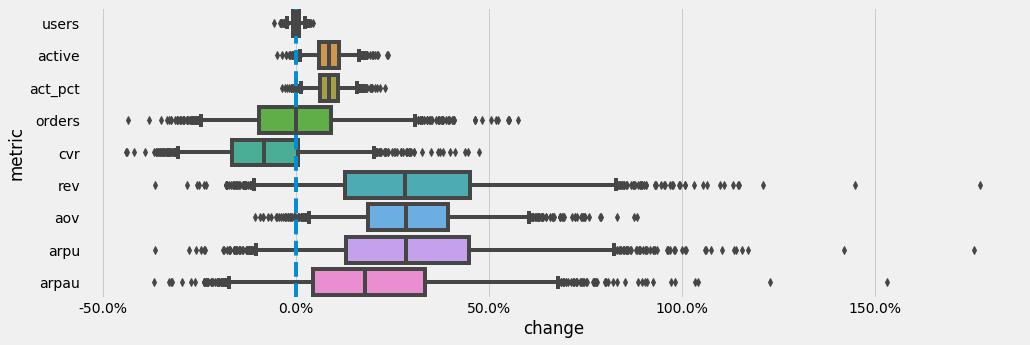

In [5]:
def analyse(stats, low=0.025, high=0.975, test='B', control='A'):
    df = stats.copy()
    for g in (test, control):
        df[f'act_pct_{g}'] = df[f'active_{g}'] / df[f'users_{g}']  # Convertion from Active to Order
        df[f'cvr_{g}'] = df[f'orders_{g}'] / df[f'active_{g}']  # Convertion from Active to Order
        df[f'aov_{g}'] = df[f'rev_{g}'] / df[f'orders_{g}']  # Average Order Value
        df[f'arpu_{g}'] = df[f'rev_{g}'] / df[f'users_{g}']  # Average Reveue per User
        df[f'arpau_{g}'] = df[f'rev_{g}'] / df[f'active_{g}']  # Average Reveue per Active User

    metrics = ['users', 'active', 'act_pct', 'orders', 'cvr', 'rev', 'aov', 'arpu', 'arpau']
    for metric in metrics:
        df[metric] = df[f'{metric}_{test}'] / df[f'{metric}_{control}'] - 1  # Ratio between Test and Control

    box(df[metrics], low, high)
    summary = df[metrics].quantile([low, 0.5, high]).T
    return summary


summary = analyse(stats)
summary.style.format('{:+.2%}')